# Finetune ResNet50


With 1000 x 400 melspectrogram images with online data augmentation (stochastic Gaussian noise), with a lower maximum standard deviation value


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50_augmented_stochastic'

train_csv = '../../data/melspectrogram_train_dataset.csv'
test_csv = '../../data/melspectrogram_test_dataset.csv'
root_dir = '../../data/'

Custom dataset class for loading the precomputed tensors of the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the testing/evaluation function


In [8]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100

    return test_loss, test_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Check if current model is best performing using test_accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)),
             test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define a class to add Gaussian noise to the mel spectrogram images for online data augmentation


In [14]:
from data_augmentation.AddGaussianNoiseStochastic import AddGaussianNoiseStochastic

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define train transformations, also the online data augmentation
train_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    AddGaussianNoiseStochastic(mean=0.0, std_range=(0.0, 0.05), p=0.5
                               ),  # Online noise augmentation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Define test transformations
test_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


training: 100%|██████████| 395/395 [00:47<00:00,  8.38it/s, Loss=1.2886213064193726, Elapsed=57.9395s, ETA=0.0000s] 


Epoch 1 completed in 81.4733s
Train Loss: 1.4514972979509377 - Train Accuracy: 43.36650903262827
Test Loss: 1.3313034953493061 - Test Accuracy: 48.48436881677879

Epoch 2/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.202476143836975, Elapsed=57.0200s, ETA=0.0000s]  


Epoch 2 completed in 80.4721s
Train Loss: 1.3156964878492718 - Train Accuracy: 48.5783256494984
Test Loss: 1.263240574586271 - Test Accuracy: 50.19390581717451

Epoch 3/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.49it/s, Loss=1.2424190044403076, Elapsed=56.9485s, ETA=0.0000s] 


Epoch 3 completed in 80.3640s
Train Loss: 1.287350127968607 - Train Accuracy: 49.36781495478739
Test Loss: 1.263423002127445 - Test Accuracy: 50.93787099327266

Epoch 4/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.47it/s, Loss=1.3876926898956299, Elapsed=57.1042s, ETA=0.0000s] 


Epoch 4 completed in 80.9179s
Train Loss: 1.2639609065236925 - Train Accuracy: 50.519400858742756
Test Loss: 1.2677485268525404 - Test Accuracy: 49.67154728927582

Epoch 5/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.47it/s, Loss=1.138187050819397, Elapsed=57.0547s, ETA=0.0000s]  


Epoch 5 completed in 80.6780s
Train Loss: 1.2472605222388158 - Train Accuracy: 51.257444745641976
Test Loss: 1.2297698536304513 - Test Accuracy: 51.958844479620105

Epoch 6/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.47it/s, Loss=1.254420518875122, Elapsed=57.0420s, ETA=0.0000s]  


Epoch 6 completed in 80.6229s
Train Loss: 1.2330243714248077 - Train Accuracy: 51.79564296879637
Test Loss: 1.2048315050626042 - Test Accuracy: 53.27265532251681

Epoch 7/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.2414536476135254, Elapsed=57.0091s, ETA=0.0000s] 


Epoch 7 completed in 80.4789s
Train Loss: 1.2302506166168405 - Train Accuracy: 52.244801044737734
Test Loss: 1.2357723724962486 - Test Accuracy: 51.78472497032054

Epoch 8/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.45it/s, Loss=1.2462908029556274, Elapsed=57.2226s, ETA=0.0000s] 


Epoch 8 completed in 80.8030s
Train Loss: 1.2184455002410501 - Train Accuracy: 52.70187380043135
Test Loss: 1.2293822030828456 - Test Accuracy: 51.48397309062129

Epoch 9/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.1770248413085938, Elapsed=57.0229s, ETA=0.0000s] 


Epoch 9 completed in 80.7718s
Train Loss: 1.2123873260956777 - Train Accuracy: 52.68010843111261
Test Loss: 1.1872293515638872 - Test Accuracy: 53.86624455876533

Epoch 10/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.49it/s, Loss=1.1835227012634277, Elapsed=56.9561s, ETA=0.0000s] 


Epoch 10 completed in 80.5259s
Train Loss: 1.2062994913209844 - Train Accuracy: 53.19654128494826
Test Loss: 1.179706457287374 - Test Accuracy: 54.32528690146419

Epoch 11/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.45it/s, Loss=1.2455002069473267, Elapsed=57.3212s, ETA=0.0000s] 


Epoch 11 completed in 80.9490s
Train Loss: 1.1980596555939202 - Train Accuracy: 53.39836561863116
Test Loss: 1.1738030729871807 - Test Accuracy: 54.58646616541354

Epoch 12/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.47it/s, Loss=1.0308959484100342, Elapsed=57.0767s, ETA=0.0000s] 


Epoch 12 completed in 80.8893s
Train Loss: 1.1895509538771232 - Train Accuracy: 53.619976651694735
Test Loss: 1.1979043254948625 - Test Accuracy: 53.46260387811634

Epoch 13/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.49it/s, Loss=1.2320021390914917, Elapsed=56.9406s, ETA=0.0000s] 


Epoch 13 completed in 80.3806s
Train Loss: 1.185171955144858 - Train Accuracy: 54.027582658936666
Test Loss: 1.1570511893792585 - Test Accuracy: 55.23545706371191

Epoch 14/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.2389323711395264, Elapsed=57.2335s, ETA=0.0000s] 


Epoch 14 completed in 80.8925s
Train Loss: 1.174224994152407 - Train Accuracy: 54.57171689190526
Test Loss: 1.1661950638799956 - Test Accuracy: 55.11673921646221

Epoch 15/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.49it/s, Loss=1.0292147397994995, Elapsed=56.9360s, ETA=0.0000s] 


Epoch 15 completed in 80.7558s
Train Loss: 1.1718550669996044 - Train Accuracy: 54.730010486950675
Test Loss: 1.1732123897533224 - Test Accuracy: 54.9980213692125

Epoch 16/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.0810388326644897, Elapsed=56.9921s, ETA=0.0000s] 


Epoch 16 completed in 80.5168s
Train Loss: 1.1666453698013401 - Train Accuracy: 54.94568551020005
Test Loss: 1.1477324089618643 - Test Accuracy: 55.79738820736051

Epoch 17/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.0636152029037476, Elapsed=57.1174s, ETA=0.0000s] 


Epoch 17 completed in 80.7066s
Train Loss: 1.1688178741479223 - Train Accuracy: 54.6548210293041
Test Loss: 1.146988407529966 - Test Accuracy: 55.48872180451128

Epoch 18/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.49it/s, Loss=1.1526215076446533, Elapsed=56.9685s, ETA=0.0000s] 


Epoch 18 completed in 80.5385s
Train Loss: 1.1606843071647837 - Train Accuracy: 54.98130156908526
Test Loss: 1.1446333100097348 - Test Accuracy: 55.69449940641077

Epoch 19/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.167160987854004, Elapsed=57.0104s, ETA=0.0000s]  


Epoch 19 completed in 80.5569s
Train Loss: 1.1596226764630668 - Train Accuracy: 55.191040582520436
Test Loss: 1.1353838100577847 - Test Accuracy: 55.821131776810454

Epoch 20/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.46it/s, Loss=1.0091958045959473, Elapsed=57.1289s, ETA=0.0000s] 


Epoch 20 completed in 80.6115s
Train Loss: 1.1579342763635176 - Train Accuracy: 55.398800926017536
Test Loss: 1.1301983022930646 - Test Accuracy: 56.16937079540958

Epoch 21/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.1851084232330322, Elapsed=57.0050s, ETA=0.0000s] 


Epoch 21 completed in 80.5621s
Train Loss: 1.1456905202020573 - Train Accuracy: 55.43045964502661
Test Loss: 1.141419893563396 - Test Accuracy: 56.28808864265928

Epoch 22/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.2159374952316284, Elapsed=57.0022s, ETA=0.0000s] 


Epoch 22 completed in 80.5297s
Train Loss: 1.1456369409078284 - Train Accuracy: 55.76485486456004
Test Loss: 1.1899568950287018 - Test Accuracy: 54.24614166996439

Epoch 23/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.146420955657959, Elapsed=56.9960s, ETA=0.0000s]  


Epoch 23 completed in 80.6206s
Train Loss: 1.1454601360272758 - Train Accuracy: 55.818278952887866
Test Loss: 1.1629788911703862 - Test Accuracy: 55.8369608231104

Epoch 24/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.47it/s, Loss=1.1980780363082886, Elapsed=56.9845s, ETA=0.0000s] 


Epoch 24 completed in 80.6784s
Train Loss: 1.1495570786391633 - Train Accuracy: 55.35724885731811
Test Loss: 1.18128570703545 - Test Accuracy: 54.18282548476454

Epoch 25/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.43it/s, Loss=1.1326247453689575, Elapsed=57.3155s, ETA=0.0000s] 


Epoch 25 completed in 80.7886s
Train Loss: 1.1391580803484855 - Train Accuracy: 55.98646589762362
Test Loss: 1.1369620393020938 - Test Accuracy: 56.042738425009894



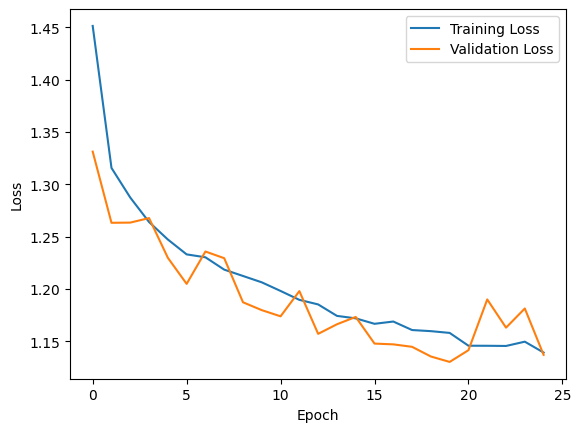

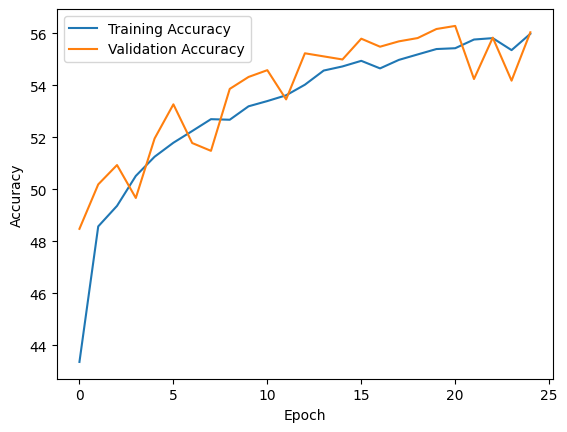

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=train_transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
    model, trainloader, testloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)

Plot confusion matrix


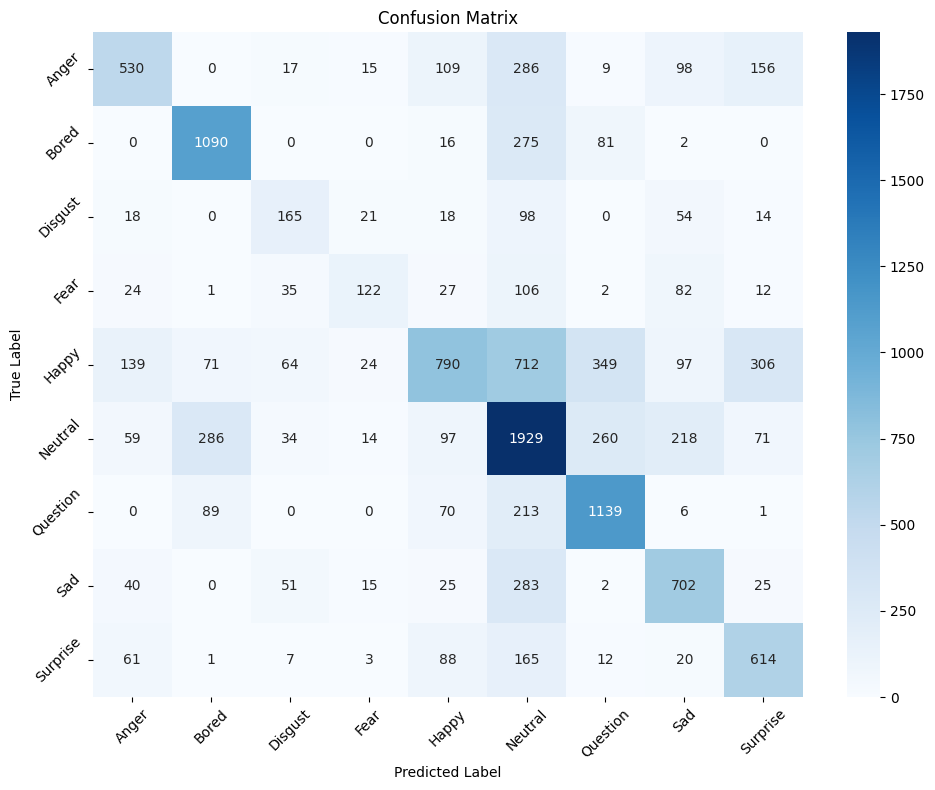

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()


# To use this function, collect predictions and true labels during testing
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)